# Radial Distribution Function for cloud clustering - Simple Example and Description
The radial distribution function measures the clustering of objects as a function of distance. It is commonly used in statistical mechanics to describe how the density of particles varies as a function of distance from a reference particle. See https://en.wikipedia.org/wiki/Radial_distribution_function

As an example let us load a typical cloud field.

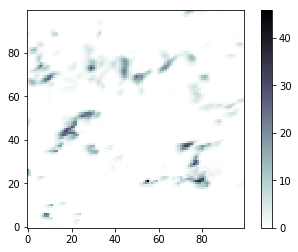

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cosmo_utils.pyncdf import getfobj_ncdf
fn = '/project/meteo/scratch/users/stephan.rasp/convective_variability_data/raw_data/2016060500/deout_ceu_pspens/det/OUTPUT/lfff00150000.nc_30m_surf'
prec_field = getfobj_ncdf(fn, 'PREC_ACCUM').data
plt.imshow(prec_field[100:200, 100:200], cmap='bone_r', origin='lower')
plt.colorbar()

The first step is to create a binary field using a threshold. For precipitation I am using a threshold of 1 mm/h. Then we can identify continuous objects as grid points which share a common border. Insporation comes from this great example: https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/

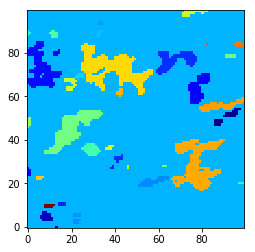

In [3]:
from cosmo_utils.diag import identify_clouds
threshold = 1.
labels = identify_clouds(prec_field, threshold, water=False)[0]
# Shuffle data to make more visible
b = np.arange(labels.max() + 1)
np.random.shuffle(b)
shuffledLw = b[labels]
plt.imshow(shuffledLw[100:200, 100:200], cmap='jet', origin='lower')

### Cloud separation
We can also further separate the identified objects using a local maximum filter. This filter identifies the local maxima for each object. From these maxima a watershed algorith is used to define the extent of each sub-object.

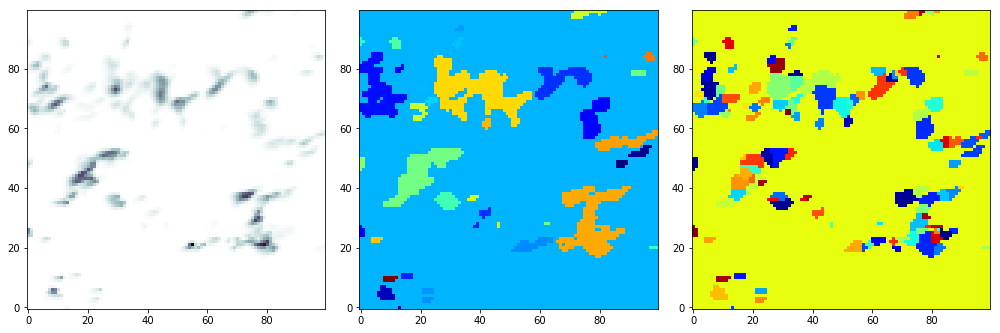

In [4]:
labels_sep = identify_clouds(prec_field, threshold, water=True)[0]
# Shuffle data to make more visible
b = np.arange(labels_sep.max() + 1)
np.random.shuffle(b)
shuffledLw_sep = b[labels_sep]
fig, axarr = plt.subplots(1, 3, figsize=(14, 5))
axarr[0].imshow(prec_field[100:200, 100:200], cmap='bone_r', origin='lower')
axarr[1].imshow(shuffledLw[100:200, 100:200], cmap='jet', origin='lower')
axarr[2].imshow(shuffledLw_sep[100:200, 100:200], cmap='jet', origin='lower')
plt.tight_layout()

As you can see, the cloud separation algorithm separates the clouds very agressively. It certainly seems like some of the separated cloud objects are too small. The unseparated cloud objects, on the other, hand appear to be too large. Of course, some tuning could be done with the threshold. But which value to chose?

## Computing the RDF
The first step to compute the RDF is compute the centers of mass of each identified object. This is already done inside the calc_rdf() function. 

Then we have to define some parameters:

1. The maximum search radius **r_max**
2. The bin size **dr**

### Mathematical formulation
We are computing a distrete version of the RDF in 2D.

The normalized RDF $g(r)$ is given by
$$g(r) = \frac{\langle N (r \pm 0.5 \Delta r) \rangle}{A (r \pm 0.5 \Delta r)} \frac{1}{\rho} $$
where $N (r \pm 0.5 \Delta r)$ is the number of objects in the interval $r \pm 0.5 \Delta r$ and the angled brackets indicate the ensemble mean over all objects. $A (r \pm 0.5 \Delta r)$ is the area of the annulus, which is given by $2 \pi r \Delta r$. $\rho$ is the domain mean object density. 

The RDF which is normalized by the domain mean density is therefore unitless and gives the following information: "How much more likely is an object located within a distance interval $[r - \Delta r, r + \Delta r]$ to another object, compared to a completely random distribution of objects in the domain?" A completely random distribution therefore has a value of 1 at all radii.

#### Non-normalized version
It can be insightful to also compute the non-normalized version of the RDF, which I will denote here as $n(r) = g(r) * \rho$. This metric then has units [objects per $m^2$] and can be interpreted as: "How many objects per unit area can be found within a distance interval $[r - \Delta r, r + \Delta r]$ to another object?" This metric can be advantageous when comparing RDFs with very different total densities $\rho$, depending on the research question.

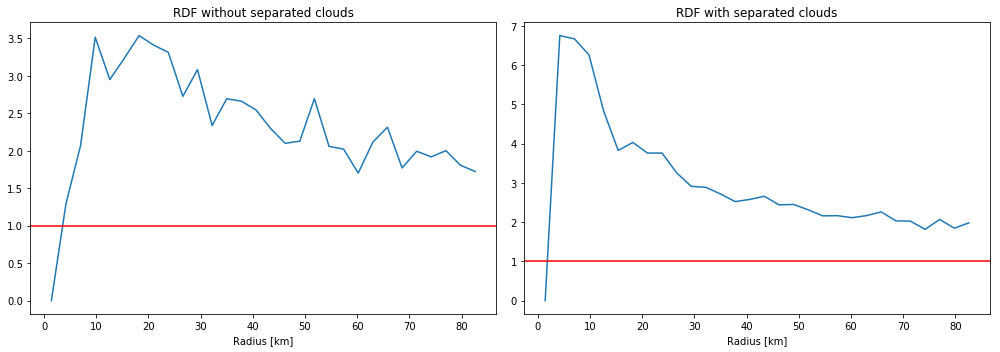

In [16]:
import sys
sys.path.append('../python_scripts')
from helpers import calc_rdf, pair_correlation_2d

r_max = 30   # In grid points
dr = 1       # Also in grid points

fig, axarr = plt.subplots(1, 2, figsize=(14, 5))
rdf, radii = calc_rdf(labels, prec_field, normalize=True, dx=2.8e3, r_max=r_max, dr=dr)
axarr[0].plot(radii / 1000., rdf)
axarr[0].set_title('RDF without separated clouds')
axarr[0].set_xlabel('Radius [km]')
axarr[0].axhline(1, c='r')

rdf, radii = calc_rdf(labels_sep, prec_field, normalize=True, dx=2.8e3, r_max=r_max, dr=dr)
axarr[1].plot(radii / 1000., rdf)
axarr[1].set_title('RDF with separated clouds')
axarr[1].set_xlabel('Radius [km]')
axarr[1].axhline(1, c='r')

plt.tight_layout()

As you can see the shape of the function depends heavily on whether the cloud objects are separated with the local maximum filter or not. A separation typically leads to a peak at $r = 2 \Delta x$, moslt likely due to the many very small objects. The corve for the non-separated clouds has a broader peak somewhere around $r = 10 - 20 km$. The exact value and shape of the RDF is probably not to be taken that seriously then. When comparing different fields, it is probably important to compare both settings and check the sensitivity of the results.

The message from these plots is that it is much more likely that clouds are located in close proximity to already existing clouds.

#### A note on the first bin
The first bin is necessarily always zero. Two clouds which are immediately touching must be one object!

#### How to handle boundaries?
There is two boundary situations.

1. Data is available in the entire analysis domain (for example, full model output)
2. Data is available only in part of the domain (for example, radar domain)

In both situations, only identified centers of mass are taken for the RDF computation where the entire circle of radius r_max is within the domain where data is available.